In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from nltk import ngrams
from collections import Counter

In [3]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [5]:
oal_review_naive_count = pd.read_sql("""
                                     SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                     FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                     JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                         ON a.item_id = oal.openalex_id 
                                     WHERE oal_type = 'article' AND (LOWER(a.abstract_plain_text) ~ 'review' OR LOWER(item_title) ~ 'review')
                                     GROUP BY pubyear
                                     """, 
                                     con=engine)

In [6]:
oal_review_naive_count.n.sum()

508109

In [27]:
oal_review_naive_count_ref1 = pd.read_sql("""
                                          SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                          FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                          JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                              ON a.item_id = oal.openalex_id 
                                          WHERE oal_type = 'article' AND source_ref_count >= 1 AND (LOWER(a.abstract_plain_text) ~ 'review' OR LOWER(item_title) ~ 'review')
                                          GROUP BY pubyear
                                          """, 
                                          con=engine)

In [28]:
oal_review_naive_count_ref1.n.sum()

472770

In [29]:
oal_review_naive_count_ref100 = pd.read_sql("""
                                            SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                            FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                            JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                                ON a.item_id = oal.openalex_id 
                                            WHERE oal_type = 'article' AND source_ref_count >= 100 AND (LOWER(a.abstract_plain_text) ~ 'review' OR LOWER(item_title) ~ 'review')
                                            GROUP BY pubyear
                                            """, 
                                            con=engine)

In [30]:
oal_review_naive_count_ref100.n.sum()

76289

In [7]:
oal_review_regex_count = pd.read_sql("""
                                     SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                     FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                     JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                         ON a.item_id = oal.openalex_id 
                                     WHERE oal_type = 'article' 
                                         AND ( 
                                             LOWER(a.abstract_plain_text) ~ '(\sthis\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                                             OR LOWER(item_title) ~ '(\sa\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                                         )
                                     GROUP BY pubyear
                                     """, 
                                     con=engine)

In [8]:
oal_review_regex_count.n.sum()

164738

In [10]:
oal_review_ref_count = pd.read_sql("""
                                   SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                   FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                   WHERE oal_type = 'article' AND source_ref_count >= 100
                                   GROUP BY pubyear
                                   """, 
                                   con=engine)

In [11]:
oal_review_ref_count.n.sum()

463551

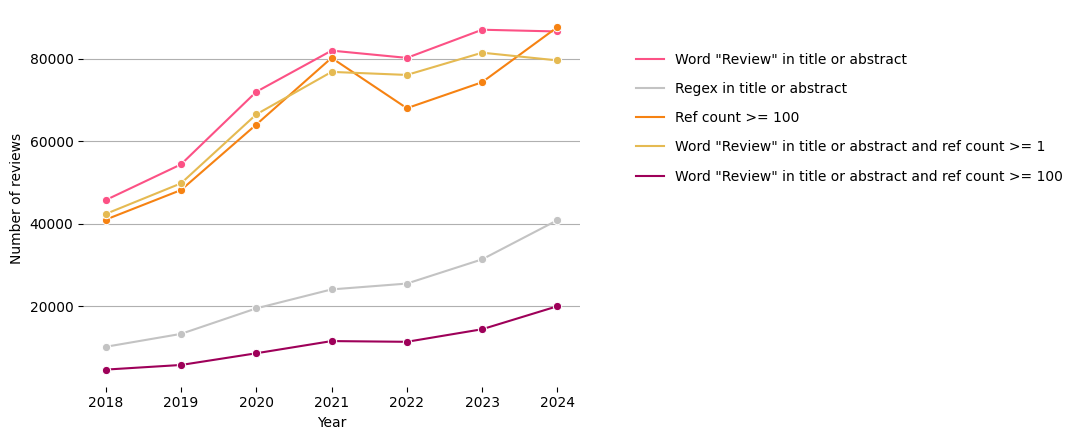

In [43]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_review_naive_count,
             x='pubyear',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_review_regex_count,
             x='pubyear',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_review_ref_count,
             x='pubyear',
             y='n',
             color='#f68212',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_review_naive_count_ref1,
             x='pubyear',
             y='n',
             color='#E5BA52',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_review_naive_count_ref100,
             x='pubyear',
             y='n',
             color='#9e0059',
             marker='o',
             ax=ax)

ax.grid(True, which='both', axis='y')
ax.set(xlabel='Year', ylabel='Number of reviews')
ax.ticklabel_format(useOffset=False, style='plain')

nai_patch = Line2D([0], [0], color='#fc5185', label='Word "Review" in title or abstract')
ref1_patch = Line2D([0], [0], color='#E5BA52', label='Word "Review" in title or abstract and ref count >= 1')
ref100_patch = Line2D([0], [0], color='#9e0059', label='Word "Review" in title or abstract and ref count >= 100')
reg_patch = Line2D([0], [0], color='#c3c3c3', label='Regex in title or abstract')
ref_patch = Line2D([0], [0], color='#f68212', label='Ref count >= 100')

lgd = fig.legend(handles=[nai_patch, reg_patch, ref_patch, ref1_patch, ref100_patch], frameon=False,
                 bbox_to_anchor=(1.8, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/review_classification_comparison.png', format='png', bbox_inches='tight', dpi=500)

In [4]:
oal_scp_diff = pd.read_sql("""
                           SELECT COUNT(DISTINCT(doi)) AS n
                           FROM unignhaupka.oal_scp_review_analysis
                           """, 
                           con=engine)

In [5]:
oal_scp_diff

,n
0,553716


In [6]:
oal_scp_diff_journals = pd.read_sql("""
                                    SELECT source_title, COUNT(DISTINCT(doi)) AS n
                                    FROM unignhaupka.oal_scp_review_analysis
                                    GROUP BY source_title
                                    ORDER BY n DESC
                                    """, 
                                    con=engine)

In [7]:
oal_scp_diff_journals.head(20)

,source_title,n
0,Medicine,3829
1,Sustainability,3502
2,PubMed,3307
3,Applied Sciences,2932
4,Energies,2582
5,Coordination Chemistry Reviews,2384
6,TrAC Trends in Analytical Chemistry,2121
7,DOAJ (DOAJ: Directory of Open Access Journals),1905
8,Deleted Journal,1749
9,Renewable and Sustainable Energy Reviews,1746


In [14]:
oal_review = pd.read_sql("""
                         SELECT doi, item_title
                         FROM unignhaupka.oal_scp_review_analysis osra
                         JOIN fiz_openalex_bdb_20250201.abstracts AS a
                             ON a.item_id = osra.openalex_id 
                         WHERE LOWER(a.abstract_plain_text) ~ '(\sthis\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                             OR LOWER(item_title) ~ '(\sa\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                         LIMIT 100
                         """, 
                         con=engine)

In [15]:
oal_review.head(20)

,doi,item_title
0,10.3399/bjgp20x709265,Should we be prescribing testosterone to perim...
1,10.1117/1.jatis.7.2.020902,Glass ceramic ZERODUR®: Even closer to zero th...
2,10.3390/fire6050175,Fire Retardance Methods and Materials for Phas...
3,10.1136/egastro-2023-000003,Spatial dimension of macrophage heterogeneity ...
4,10.1177/2150135120956938,American Society of ExtraCorporeal Technology:...
5,10.1360/n972018-00502,Preparation and properties of polyoxo-titanium...
6,10.5152/etd.2017.17007,PET-MRI Imaging of Cellular Trafficking of Lip...
7,10.1155/2020/8025391,Coccidioidomycosis of the Vocal Cords Presenti...
8,10.22141/2224-0721.16.4.2020.208489,Hashimoto’s thyroiditis: modern views on the p...
9,10.7498/aps.69.20200083,High resolution imaging based on photo-emissio...


In [17]:
reg_review_per_year = pd.read_sql("""
                                  SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                  FROM unignhaupka.oal_scp_review_analysis osra
                                  JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                      ON a.item_id = osra.openalex_id 
                                  WHERE LOWER(a.abstract_plain_text) ~ '(\sthis\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                                      OR LOWER(item_title) ~ '(\sa\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                                  GROUP BY pubyear
                                  """, 
                                  con=engine)

In [18]:
scp_review_per_year = pd.read_sql("""
                                   SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                   FROM unignhaupka.oal_scp_review_analysis
                                   WHERE scp_type = 'Review'
                                   GROUP BY pubyear
                                   """, 
                                   con=engine)

In [16]:
ref_review_per_year = pd.read_sql("""
                                  SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                  FROM unignhaupka.oal_scp_review_analysis
                                  WHERE source_ref_count >= 100
                                  GROUP BY pubyear
                                  """, 
                                  con=engine)

In [19]:
nai_review_per_year = pd.read_sql("""
                                  SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                  FROM unignhaupka.oal_scp_review_analysis osra
                                  JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                      ON a.item_id = osra.openalex_id 
                                  WHERE LOWER(a.abstract_plain_text) ~ 'review'
                                      OR LOWER(item_title) ~ 'review'
                                  GROUP BY pubyear
                                  """, 
                                  con=engine)

In [34]:
nai_ref1_review_per_year = pd.read_sql("""
                                       SELECT COUNT(DISTINCT(doi)) AS n, pubyear
                                       FROM unignhaupka.oal_scp_review_analysis osra
                                       JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                           ON a.item_id = osra.openalex_id 
                                       WHERE source_ref_count >= 1 AND (LOWER(a.abstract_plain_text) ~ 'review' OR LOWER(item_title) ~ 'review')
                                       GROUP BY pubyear
                                       """, 
                                       con=engine)

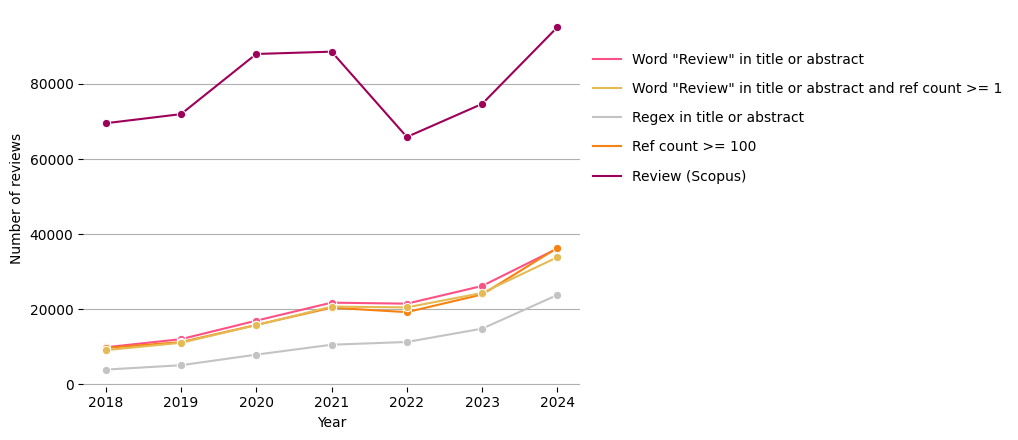

In [45]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=nai_review_per_year,
             x='pubyear',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=reg_review_per_year,
             x='pubyear',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=ref_review_per_year,
             x='pubyear',
             y='n',
             color='#f68212',
             marker='o',
             ax=ax)

sns.lineplot(data=scp_review_per_year,
             x='pubyear',
             y='n',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=nai_ref1_review_per_year,
             x='pubyear',
             y='n',
             color='#E5BA52',
             marker='o',
             ax=ax)

ax.grid(True, which='both', axis='y')
ax.set(xlabel='Year', ylabel='Number of reviews')
ax.ticklabel_format(useOffset=False, style='plain')

nai_patch = Line2D([0], [0], color='#fc5185', label='Word "Review" in title or abstract')
ref1_patch = Line2D([0], [0], color='#E5BA52', label='Word "Review" in title or abstract and ref count >= 1')
reg_patch = Line2D([0], [0], color='#c3c3c3', label='Regex in title or abstract')
ref_patch = Line2D([0], [0], color='#f68212', label='Ref count >= 100')
scp_patch = Line2D([0], [0], color='#9e0059', label='Review (Scopus)')

lgd = fig.legend(handles=[nai_patch, ref1_patch, reg_patch, ref_patch, scp_patch], frameon=False,
                 bbox_to_anchor=(1.7, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/review_classification.png', format='png', bbox_inches='tight', dpi=500)

In [46]:
reg_review_per_year.n.sum()

77493

In [47]:
scp_review_per_year.n.sum()

553719

In [48]:
ref_review_per_year.n.sum()

136787

In [49]:
nai_review_per_year.n.sum()

144546

In [50]:
nai_ref1_review_per_year.n.sum()

135400

In [51]:
abstract_null_count = pd.read_sql("""
                                  SELECT COUNT(DISTINCT(doi)) AS n
                                   FROM unignhaupka.oal_scp_review_analysis osra
                                   JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                       ON a.item_id = osra.openalex_id 
                                   WHERE abstract_plain_text IS NULL
                                   """, 
                                   con=engine)

In [52]:
abstract_null_count.n

0    285753
Name: n, dtype: int64

In [91]:
oal_title_analysis = pd.read_sql("""
                                 SELECT openalex_id, item_title
                                 FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                 WHERE oal_type = 'review'
                                 ORDER BY RANDOM()
                                 LIMIT 10000
                                 """, 
                                 con=engine)

In [92]:
oal_title_analysis.item_title

0       Genetic Imaging of Neuroinflammation in Parkin...
1       2023 American Heart Association Focused Update...
2       The Mycobiome: Cancer Pathogenesis, Diagnosis,...
3       Engineered Bacteria-Based Living Materials for...
4        A Bibliometric Review of the Mathematics Journal
                              ...                        
9995    Spirituality, Religion and Breastfeeding: A Sc...
9996    Recent insights into greywater treatment: a co...
9997    Late-maturity α-amylase (LMA): exploring the u...
9998    World Trade Center Exposure, DNA Methylation C...
9999    A comprehensive review on unethical honey: Val...
Name: item_title, Length: 10000, dtype: object

In [93]:
list_of_trigrams = []
for index, row in oal_title_analysis.iterrows():
    trigrams = ngrams(row['item_title'].lower().split(), 3)
    for trigram in trigrams: 
        if 'review' in trigram or 'meta' in trigram:
            list_of_trigrams.append(trigram)

In [95]:
Counter(list_of_trigrams)

Counter({('a', 'systematic', 'review'): 1309,
         ('systematic', 'review', 'and'): 723,
         ('review', 'and', 'meta-analysis'): 562,
         ('a', 'review', 'of'): 344,
         ('review', 'of', 'the'): 274,
         ('systematic', 'review', 'of'): 218,
         ('a', 'scoping', 'review'): 203,
         ('a', 'comprehensive', 'review'): 133,
         ('a', 'narrative', 'review'): 124,
         ('a', 'review', 'on'): 118,
         ('a', 'literature', 'review'): 74,
         ('a', 'critical', 'review'): 74,
         ('review', 'and', 'meta‐analysis'): 69,
         ('and', 'literature', 'review'): 68,
         ('and', 'review', 'of'): 54,
         ('review', 'on', 'the'): 47,
         ('review', 'of', 'literature'): 43,
         ('comprehensive', 'review', 'of'): 41,
         ('systematic', 'review', 'with'): 38,
         ('scoping', 'review', 'of'): 35,
         ('critical', 'review', 'of'): 32,
         ('comprehensive', 'review', 'on'): 29,
         ('a', 'review', 'and'): 2

In [81]:
oal_abstract_analysis = pd.read_sql("""
                                    SELECT item_id, abstract_plain_text
                                    FROM fiz_openalex_bdb_20250201.abstracts a 
                                    JOIN unignhaupka.oal_scp_corpus_2018_2024 as oal
                                        ON a.item_id = oal.openalex_id
                                    WHERE abstract_plain_text IS NOT NULL
                                        AND oal_type = 'review'
                                    ORDER BY RANDOM()
                                    LIMIT 10000
                                    """, 
                                    con=engine)

In [82]:
oal_abstract_analysis.abstract_plain_text

0       Abstract Although Coronavirus disease 2019 (CO...
1       Abstract Wire-arc additive manufacturing (WAAM...
2       The female reproductive system is essential to...
3       Glioblastoma, as the most aggressive brain tum...
4       Hematopoietic stem cell transplantation (HCT) ...
                              ...                        
9995    Non-invasive focused ultrasound stimulation (F...
9996    Due to high mortality rates and poor prognosis...
9997    SuperAging deserves special attention from res...
9998    Anthrax is an especially dangerous zooanthropo...
9999    Oxidative stress, caused by the formation of f...
Name: abstract_plain_text, Length: 10000, dtype: object

In [87]:
list_of_trigrams = []
for index, row in oal_abstract_analysis.iterrows():
    trigrams = ngrams(row['abstract_plain_text'].lower().split(), 3)
    for trigram in trigrams: 
        if 'review' in trigram or 'meta' in trigram:
            list_of_trigrams.append(trigram)

In [88]:
Counter(list_of_trigrams)

Counter({('a', 'systematic', 'review'): 489,
         ('this', 'systematic', 'review'): 420,
         ('systematic', 'review', 'and'): 377,
         ('of', 'this', 'review'): 360,
         ('review', 'of', 'the'): 350,
         ('review', 'aims', 'to'): 294,
         ('review', 'is', 'to'): 293,
         ('this', 'review', 'is'): 282,
         ('we', 'review', 'the'): 274,
         ('review', 'and', 'meta-analysis'): 247,
         ('systematic', 'review', 'of'): 232,
         ('this', 'review', 'aims'): 185,
         ('a', 'review', 'of'): 184,
         ('in', 'this', 'review'): 170,
         ('this', 'review', 'will'): 170,
         ('this', 'review', 'summarizes'): 167,
         ('this', 'review', 'provides'): 150,
         ('here,', 'we', 'review'): 150,
         ('review', 'focuses', 'on'): 148,
         ('the', 'present', 'review'): 148,
         ('review', 'was', 'to'): 147,
         ('review', 'aimed', 'to'): 136,
         ('review', 'summarizes', 'the'): 135,
         ('this', 

In [85]:
list_of_bigrams = []
for index, row in oal_abstract_analysis.iterrows():
    bigrams = ngrams(row['abstract_plain_text'].lower().split(), 2)
    for bigram in bigrams: 
        if 'review' in bigram or 'meta' in bigram:
            list_of_bigrams.append(bigram)

In [86]:
Counter(list_of_bigrams)

Counter({('this', 'review'): 2591,
         ('systematic', 'review'): 1302,
         ('review', 'of'): 856,
         ('review', 'the'): 543,
         ('review', 'and'): 492,
         ('we', 'review'): 475,
         ('review', 'is'): 453,
         ('review', 'was'): 412,
         ('the', 'review'): 405,
         ('review', 'aims'): 309,
         ('scoping', 'review'): 308,
         ('literature', 'review'): 280,
         ('review', 'will'): 267,
         ('a', 'review'): 218,
         ('review', 'provides'): 212,
         ('review', 'summarizes'): 212,
         ('to', 'review'): 183,
         ('present', 'review'): 157,
         ('review', 'focuses'): 153,
         ('comprehensive', 'review'): 146,
         ('review', 'aimed'): 139,
         ('narrative', 'review'): 138,
         ('review', 'highlights'): 112,
         ('review', 'discusses'): 110,
         ('our', 'review'): 90,
         ('review', 'to'): 89,
         ('review', 'on'): 82,
         ('systematically', 'review'): 82,
   

In [4]:
oal_review_scp_other = pd.read_sql("""
                                   SELECT COUNT(DISTINCT(doi)) AS n, oal_type, scp_type
                                   FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                   JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                       ON a.item_id = oal.openalex_id 
                                   WHERE oal_type = 'article' AND source_ref_count >= 1
                                       AND (LOWER(a.abstract_plain_text) ~ 'review' OR LOWER(item_title) ~ 'review')
                                   GROUP BY oal_type, scp_type
                                   """, 
                                   con=engine)

In [5]:
oal_review_scp_other

,n,oal_type,scp_type
0,302348,article,Article
1,3,article,Article in Press
2,2,article,Book
3,112,article,Chapter
4,14167,article,Conference Paper
5,352,article,Data Paper
6,4850,article,Editorial
7,319,article,Erratum
8,4947,article,Letter
9,7888,article,Note


In [6]:
oal_review_scp_other_reg = pd.read_sql("""
                                       SELECT COUNT(DISTINCT(doi)) AS n, oal_type, scp_type
                                       FROM unignhaupka.oal_scp_corpus_2018_2024 as oal
                                       JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                           ON a.item_id = oal.openalex_id 
                                       WHERE oal_type = 'article' 
                                           AND ( 
                                               LOWER(a.abstract_plain_text) ~ '(\sthis\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                                               OR LOWER(item_title) ~ '(\sa\s|systematic\s|umbrealla\s|bibliographic\s|literature\s|scoping\s|comprehensive\s|mini-)review'
                                           )
                                       GROUP BY oal_type, scp_type
                                       """, 
                                       con=engine)

In [7]:
oal_review_scp_other_reg

,n,oal_type,scp_type
0,77571,article,Article
1,33,article,Chapter
2,3936,article,Conference Paper
3,87,article,Data Paper
4,1156,article,Editorial
5,244,article,Erratum
6,1124,article,Letter
7,2092,article,Note
8,77255,article,Review
9,1245,article,Short Survey


In [70]:
nai_review_not_review_included = pd.read_sql("""
                                              SELECT doi, item_title
                                              FROM unignhaupka.oal_scp_review_analysis osra
                                              JOIN fiz_openalex_bdb_20250201.abstracts AS a
                                                  ON a.item_id = osra.openalex_id 
                                              WHERE a.abstract_plain_text IS NOT NULL 
                                                  AND NOT (LOWER(a.abstract_plain_text) ~ 'review' OR LOWER(item_title) ~ 'review')
                                              LIMIT 100
                                              """, 
                                              con=engine)

In [71]:
nai_review_not_review_included.head(20)

,doi,item_title
0,10.3389/fenvs.2019.00023,Hydrologic and Agricultural Earth Observations...
1,10.22201/ib.20078706e.2018.1.1880,Patrones de riqueza y distribución latitudinal...
2,10.31192/np.16.2.2,Voting of people with intellectual disabilitie...
3,10.1590/0102-33062018abb0255,Floral biology and pollination in Brazil: hist...
4,10.18332/tid/94829,Tobacco company strategies for maintaining cig...
5,10.1302/2058-5241.3.180003,The acute Charcot foot in diabetics
6,10.31782/ijcrr.2020.123128,Healthcare Setting and Methicillin Resistant S...
7,10.46303/jcsr.2020.9,Experience with Diversity is Not Enough: A Ped...
8,10.11622/smedj.2020177,SingHealth Radiology Archives pictorial essay ...
9,10.21138/bage.2968,Las transiciones hacia la sostenibilidad como ...
